In [303]:
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins

In [304]:
from sklearn.preprocessing import MinMaxScaler

In [305]:
#set the visual style
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10000)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

In [306]:
query_dir = 'queries'

In [307]:
queries = {}
for query_file in (os.listdir(query_dir)):
    with open(os.path.join(query_dir, query_file), 'r') as query:
        queries[query_file] = query.read()

In [308]:
query_client = bigquery.Client()

In [309]:
request = queries['combined_analysis_data.sql']

In [310]:
data = query_client.query(request).to_dataframe()

In [311]:
energy_cols = ['energy_letter', 'energy_color']

for col in energy_cols:
    data[col] = 0

energy_res = [[c.strip() for c in char.split('-')] if char is not None and '-' in char else [None, None] for char in data.energy_character]
data[energy_cols] = pd.DataFrame(energy_res, columns=energy_cols)

In [312]:
data['price_per_sq_m'] = data.price / data.primary_size

In [313]:
scaler = MinMaxScaler()
data['price_per_sq_m_scaled'] = scaler.fit_transform(data['price_per_sq_m'].to_frame())

In [314]:
# data.set_index(['ad_id', 'apt_id'], drop=True)

In [315]:
data['construction_year_bin'] = pd.cut(data['construction_year'], bins=20, precision=0)

In [316]:
data.head()

,ad_id,apt_id,new_building,num_bedrooms,floor,primary_size,total_size,price,property_type,ownership_type,construction_year,energy_character,common_expenses,brokerage_expenses,common_wealth,common_debt,time_s,lat,lng,address,short_description,full_description,energy_letter,energy_color,price_per_sq_m,price_per_sq_m_scaled,construction_year_bin
0,85287718,120,True,2.0,1.0,48.0,59.0,4150000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...,None,None,86458.333333,0.462035,"(2011.0, 2019.0]"
1,85287718,143,True,2.0,2.0,56.0,61.0,4350000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...,None,None,77678.571429,0.407650,"(2011.0, 2019.0]"
2,85287718,183,True,2.0,5.0,51.0,59.0,4350000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...,None,None,85294.117647,0.454823,"(2011.0, 2019.0]"
3,85287718,187,True,2.0,5.0,48.0,59.0,4350000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...,None,None,90625.000000,0.487844,"(2011.0, 2019.0]"
4,85287718,204,True,3.0,6.0,86.0,92.0,8495000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...,None,None,98779.069767,0.538354,"(2011.0, 2019.0]"


# Geographic Distribution

In [317]:
sample_size = 1400
to_plot = data[(data.lat.notnull()) & (data.price_per_sq_m.notnull())].sample(sample_size)

m = folium.Map([59.9116, 10.7545], zoom_start=11)
#mark each station as a point
for index, row in to_plot.iterrows():
    folium.CircleMarker([row['lat'], row['lng']],
                        radius=1,
                        popup=(row['lat'], row['lng']),
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)
#convert to (n, 2) nd-array format for heatmap
properties_array = to_plot[['lat', 'lng', 'price_per_sq_m_scaled']].values

#plot heatmap
m.add_child(plugins.HeatMap(properties_array, radius=15))
m

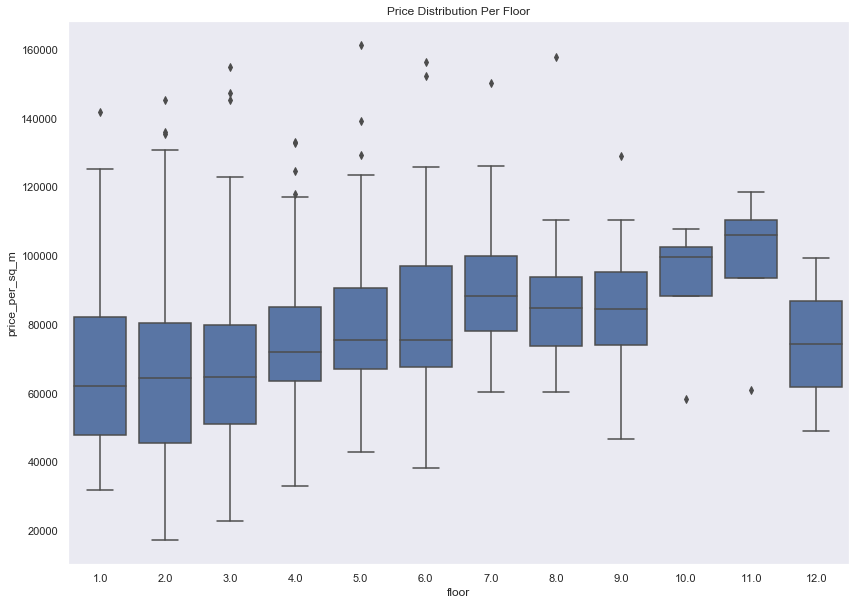

In [318]:
sns.boxplot(x='floor', y='price_per_sq_m', data=data, color='b')
plt.title('Price Distribution Per Floor')
plt.show()

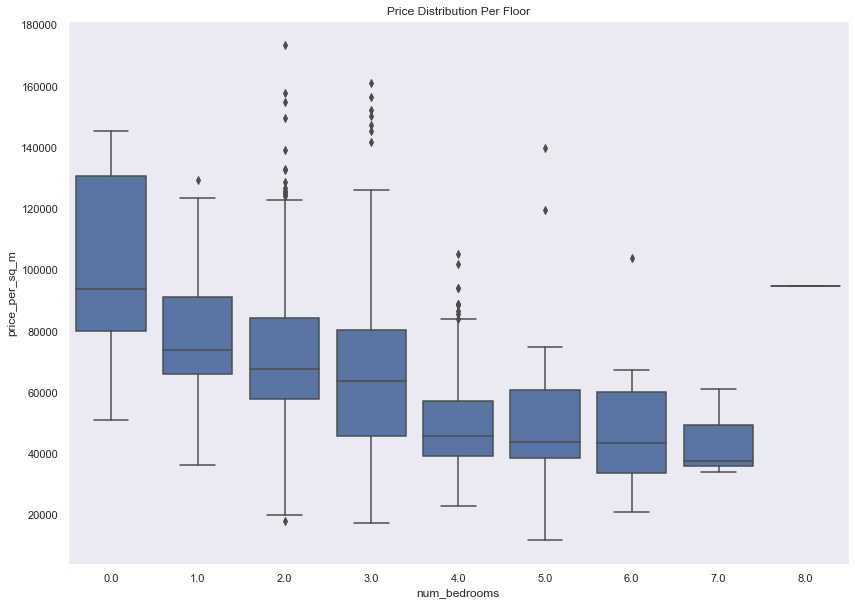

In [319]:
sns.boxplot(x='num_bedrooms', y='price_per_sq_m', data=data, color='b')
plt.title('Price Distribution Per Floor')
plt.show()

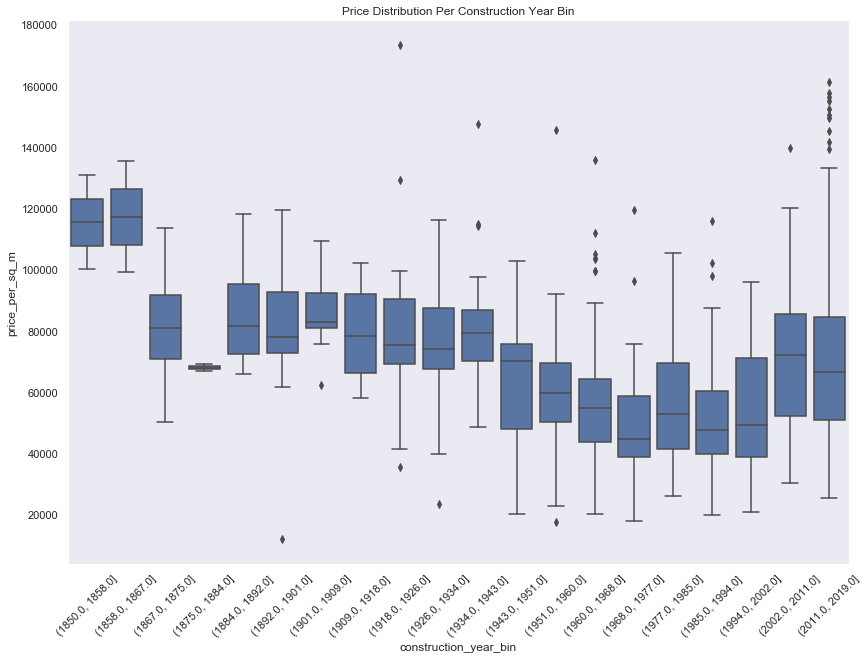

In [320]:
g = sns.boxplot(x='construction_year_bin', y='price_per_sq_m', data=data, color='b')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

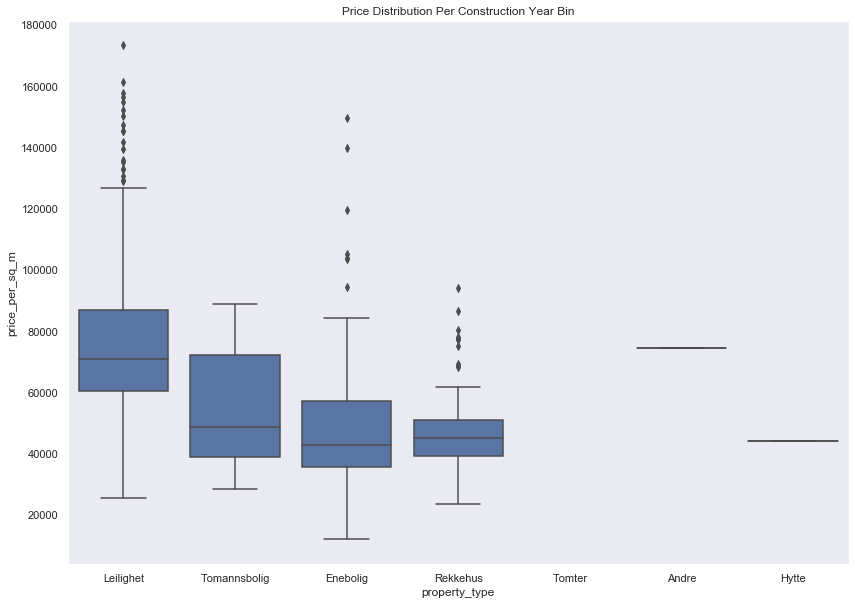

In [321]:
sns.boxplot(x='property_type', y='price_per_sq_m', data=data, color='b')
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

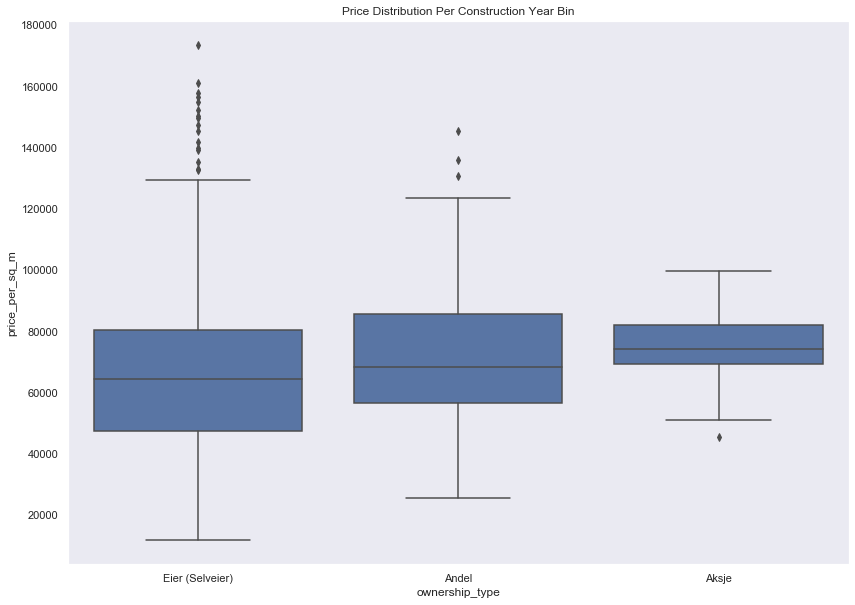

In [322]:
sns.boxplot(x='ownership_type', y='price_per_sq_m', data=data, color='b')
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

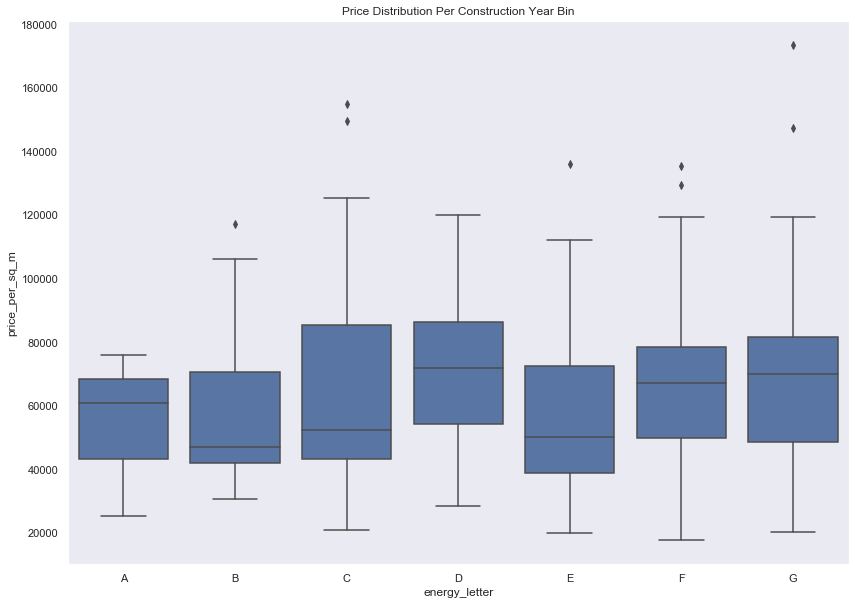

In [323]:
sns.boxplot(x='energy_letter', y='price_per_sq_m', data=data.sort_values('energy_letter'), color='b')
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

In [324]:
to_plot = data
energy_mapping = {'mørkegrønn': 1, 'lysegrønn': 2, 'gul': 3, 'oransje': 4, 'rød': 5}
to_plot['energy_color'] = to_plot['energy_color'].map(energy_mapping)

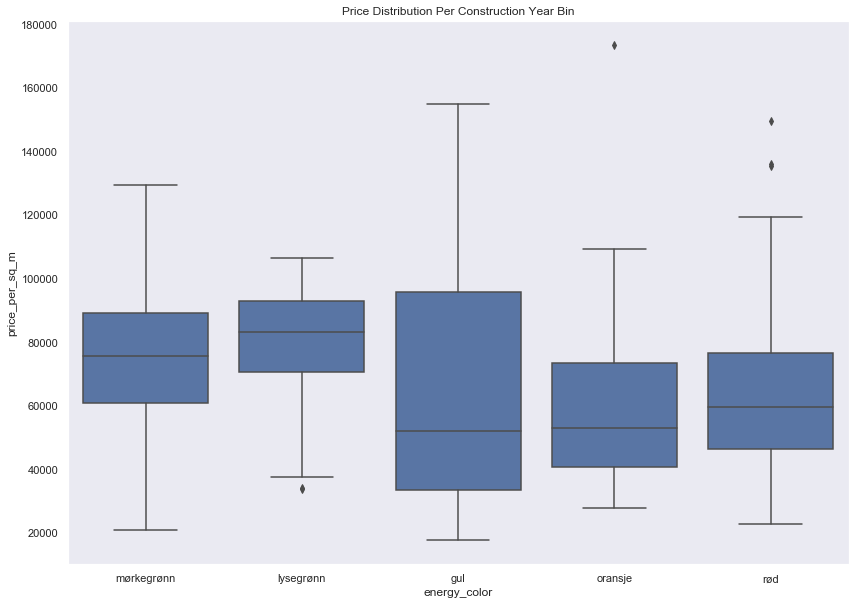

In [325]:
g = sns.boxplot(x='energy_color', y='price_per_sq_m', data=to_plot.sort_values('energy_color'), color='b')
g.set_xticklabels(energy_mapping.keys())
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

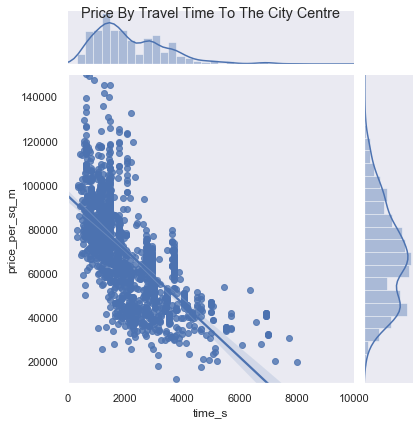

In [338]:
sns.jointplot(x='time_s', y='price_per_sq_m', data=data, xlim=(0, 1e4), ylim=(1e4, 1.5e5), kind='reg')
plt.suptitle('Price By Travel Time To The City Centre')
plt.show()